Importing the paramaterial module

In [ ]:
# import paramaterial as a module
import paramaterial as pam

# check the version of paramaterial
print(pam.__version__)

Load the raw data and metadata into a DataSet object

In [ ]:
# load the metadata spreadsheet and data files into a DataSet object
prepared_ds = pam.DataSet('info/01 prepared info.xlsx', 'data/01 prepared data')

# check the formatting of the loaded data and metadata
pam.check_formatting(prepared_ds)

Sort and Get the metadata as a pandas DataFrame

In [ ]:
# sort the dataitems in the dataset
prepared_ds = prepared_ds.sort_by(['temperature', 'lot'])

# get the metadata as a table
prepared_ds.info_table

Use the subset method to get a subset of the data

In [ ]:
# get a subset of only the tensile tests
prepared_ds = prepared_ds.subset({'test_type': ['T']})

Make an experimental matrix showing the distribution of the data

In [ ]:
# make a heatmap showing the distribution across lot and temperature
pam.experimental_matrix(prepared_ds, index='temperature', columns='lot', as_heatmap=True)

Use a Styler object to format the plotting to the entire dataset

In [ ]:
# instantiate a Styler object and format to match the prepared data
styler = pam.Styler(color_by='temperature', color_by_label='(°C)', cmap='plasma')
styler.style_to(prepared_ds)

# keys labels for stress-strain data plotting
labels_dict = dict(x='Strain', y='Stress_MPa', ylabel='Stress (MPa)')

Setup the dataset plot for a single plot of all the data

In [ ]:
# define a function to plot the dataset
def ds_plot(ds, **kwargs):
    """Takes in a DataSet and extra plotting kwargs, returns a matplotlib Axes object."""
    return pam.dataset_plot(ds=ds, styler=styler, **labels_dict, **kwargs)


# plot the dataset
ds_plot(prepared_ds)

Setup the dataset plot for a grid of plots of the data.

In [ ]:
# define a function to plot the dataset as a grid of plots
def ds_subplots(ds, **kwargs):
    """Takes in a DataSet and extra plotting kwargs, returns an array of matplotlib Axes objects."""
    return pam.dataset_subplots(
        ds=ds, shape=(6, 5), styler=styler,
        rows_by='temperature', row_vals=[[20], [100], [150], [200], [250], [300]],
        cols_by='lot', col_vals=[['A'], ['B'], ['C'], ['D'], ['E']],
        col_titles=[f'Lot {lot}' for lot in 'ABCDE'], **labels_dict, **kwargs)


# plot the dataset as a grid of plots
ds_subplots(prepared_ds)

## Processing
Find UTS and fracture point

In [34]:
# determine the ultimate tensile strength for each test
prepared_ds = pam.find_UTS(ds=prepared_ds, strain_key='Strain', stress_key='Stress_MPa')

# determine the fracture point for each test
prepared_ds = pam.find_fracture_point(
    ds=prepared_ds, strain_key='Strain', stress_key='Stress_MPa')

Trimming

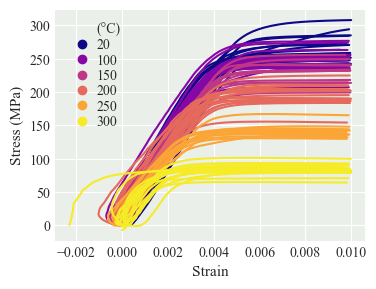

In [35]:
# define a function to trim the data to a small strain range
def trim_to_small_strain(di):
    """Takes in a DataItem and returns a trimmed DataItem."""
    di.data = di.data[di.data['Strain'] < 0.01]
    di.info['trim indices'] = (di.data['index'].min(), di.data['index'].max())
    return di


# apply the function to the dataset
trimmed_ds = prepared_ds.apply(trim_to_small_strain)

# plot the trimmed dataset
ds_plot(trimmed_ds)

Foot Correction

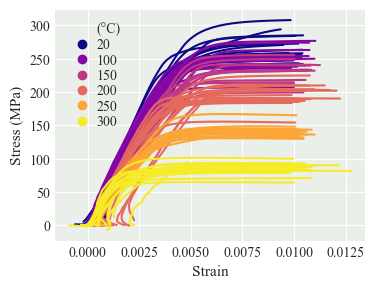

In [36]:
# determine the upper and lower proportional limits for each test
trimmed_ds = pam.find_upl_and_lpl(ds=trimmed_ds, preload=36, preload_key='Stress_MPa')

# apply the foot correction to the dataset
corrected_ds = pam.correct_foot(ds=trimmed_ds, LPL_key='LPL', UPL_key='UPL')

# plot the corrected dataset
ds_plot(corrected_ds)

Make screening pdf for foot correction screening.

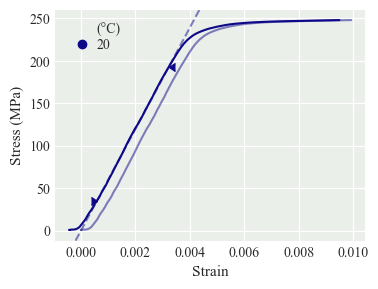

In [38]:
# define a function to plot a single test for foot correction screening
def foot_correction_screening_plot(di):
    """Takes in a DataItem and returns a matplotlib Axes object."""
    color = styler.color_dict[di.info['temperature']]
    LPL, UPL = (di.info['UPL_0'], di.info['UPL_1']), (di.info['LPL_0'], di.info['LPL_1'])
    ax = ds_plot(corrected_ds.subset({'test_id': di.test_id}))
    ax = ds_plot(trimmed_ds.subset({'test_id': di.test_id}), alpha=0.5, ax=ax)
    ax.axline(UPL, slope=di.info['E'], c=color, ls='--', alpha=0.5)
    ax.plot(*UPL, c=color, marker=4)
    ax.plot(*LPL, c=color, marker=5)
    return ax


# make the screening pdf
pam.make_screening_pdf(corrected_ds, foot_correction_screening_plot, 'info/foot-correction screening.pdf')

Reject flagged tests.

In [39]:
# read the annotated screening pdf fields to the dataset
corrected_ds = pam.read_pdf_fields_to(corrected_ds, 'info/foot-correction screening marked.pdf')

# get the metadata table of the rejected items
corrected_ds.info_table[corrected_ds.info_table['reject'] == '/Yes']

C:\Users\DS\AppData\Local\Temp\ipykernel_11404\2074701096.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  rejected_items[['test_id', 'temperature', 'lot', 'number', 'reject', 'comment']].to_latex(


Remove the rejected items

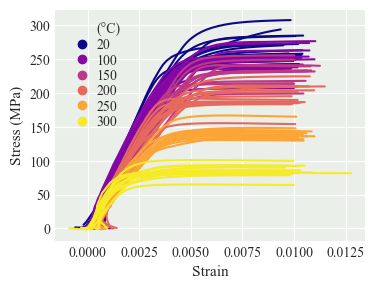

In [40]:
# remove the rejected tests from the dataset
screened_ds = pam.remove_rejected_items(corrected_ds, 'info/foot-correction screening marked.pdf')

# plot the screened dataset
ds_plot(screened_ds)

Algorithmically find the proof stresses.

In [41]:
# find the 0.2% proof stress for each test
screened_ds = pam.find_proof_stress(ds=screened_ds, proof_strain=0.2, E_key='E',
                                    strain_key='Strain', stress_key='Stress_MPa')

### Write processed data

In [42]:
# write the metadata table of the processed dataset to excel and the data to csv files
screened_ds.write_output('info/02 processed info.xlsx', 'data/02 processed data')

# load the processed dataset
processed_ds = pam.DataSet('info/02 processed info.xlsx', 'data/02 processed data')

# plot the processed dataset as a grid of plots
ds_subplots(processed_ds)

## Data Aggregation

### Representative curves

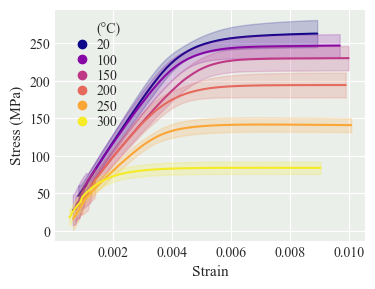

In [51]:
# make representative curves for each temperature and test type
pam.make_representative_data(
    processed_ds, 'info/03 repres info.xlsx', 'data/03 repres data', repres_col='Stress_MPa',
    group_by_keys=['temperature', 'test_type'], interp_by='Strain', interp_range='inner',
    group_info_cols=['UTS_0', 'UTS_1', 'FP_0', 'E', 'PS_0.002_0', 'PS_0.002_1', 'UPL_1'])

# load the representative dataset
repres_ds = pam.DataSet('info/03 repres info.xlsx', 'data/03 repres data', test_id_key='repres_id')

# plot the representative dataset with a shaded area for the standard deviation
ds_plot(repres_ds, fill_between=('down_std_Stress_MPa', 'up_std_Stress_MPa'))

# get the metadata table of the representative dataset
repres_ds.info_table